In [ ]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
sns.set()
from google.colab import files
from google.colab import drive
from IPython.display import Image
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
raw_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/house-prices-advanced-regression-techniques/train.csv")

In [ ]:
def convert_ordinal_to_numbers(dataframe):
    rating_sequence = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
    fence_sequence = {'NA':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4}
    garage_finish_sequence = {'NA':0, 'Unf':1, 'RFn':2, 'Fin':3}
    home_functional_sequence = {'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7}
    bsmt_fin_sequence = {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
    lot_shape_sequence = {'IR3':0, 'IR2':1, 'IR1':2, 'Reg':3}
  
    for column in dataframe.columns:
        if (column.endswith('Qual') or column.endswith('Cond') or column.endswith('QC')
            or column.endswith('Qu')) and (not column.startswith('Overall')):
            dataframe[column] = dataframe[column].map(rating_sequence)
        elif column == 'Fence':
            dataframe[column] = dataframe[column].map(fence_sequence)
        elif column == 'GarageFinish':
            dataframe[column] = dataframe[column].map(garage_finish_sequence)
        elif column == 'Functional':
            dataframe[column] = dataframe[column].map(home_functional_sequence)
        elif column == 'LotShape':
            dataframe[column] = dataframe[column].map(lot_shape_sequence)
        elif column == 'BsmtFinType1' or column == 'BsmtFinType2':
            dataframe[column] = dataframe[column].map(bsmt_fin_sequence)
        elif column == 'CentralAir':
            dataframe[column] = dataframe[column].map({'N':0, 'Y':1})
        if (str(dataframe[column].dtype) == 'object') or (column == 'MSSubClass'):
            dataframe[column] = dataframe[column].astype('category')
#       print(str(dataframe[column].dtype))
    return dataframe
    

In [ ]:
class PreProcess:
    def __init__(self):
        from sklearn.impute import SimpleImputer
        from sklearn.experimental import enable_iterative_imputer
        from sklearn.impute import IterativeImputer
        from sklearn.preprocessing import OneHotEncoder
        self.simple_imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        self.continuous_data_imputor = IterativeImputer(max_iter=2, random_state=0, verbose=2)
        self.one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
        self.drop_columns = list()
    
    def fit_categorical_imputer(self, data, fit_and_transform):
        categorical_columns = []
        for column in data.columns:
            if str(data[column].dtype) == 'category':
                categorical_columns.append(column)
        if fit_and_transform == True:
            data[categorical_columns] = self.simple_imp.fit_transform(data[categorical_columns])
        else:
            data[categorical_columns] = self.simple_imp.transform(data[categorical_columns])
        for column in categorical_columns:
            data[column] = data[column].astype('category')
        return data
      
    def select_columns_to_be_dropped(self, data):
        for column in data.columns:
        if ((1.0*data[column].isnull().sum())/data.shape[0]) > 0.81:
            self.drop_columns.append(column)
        
    def construct_one_hot_encoder_fit_transform_data(self, data, fit_and_transform):
        data_index = data.index
        category_columns = list()
        for column in data.columns:
            if str(data[column].dtype) == 'category':
                category_columns.append(column)
        category_data = data.loc[:, category_columns].copy()
        data.drop(columns=category_columns, inplace=True)

        if fit_and_transform == True:
            category_data = self.one_hot_encoder.fit_transform(category_data)
        else:
            category_data = self.one_hot_encoder.transform(category_data)

        columns = self.one_hot_encoder.get_feature_names(category_columns)
    #     print(category_data.shape, type(category_data), len(columns))
        category_data = pd.DataFrame(category_data, index=data_index, columns=columns)
        data = data.join(category_data)

        return data
    
    def fit_iterative_imputer(self, data, fit_and_transform):
        data_columns = data.columns
        data_index = data.index
        if fit_and_transform == True:
            data = self.continuous_data_imputor.fit_transform(data)
        else:
            data = self.continuous_data_imputor.transform(data)

        dataframe = pd.DataFrame(data, index=data_index, columns=data_columns)

        return dataframe
    
    

In [ ]:
def scale_data(data):
    data_max = np.abs(data).max(axis=0)
    data_max[data_max==0]=1
    data = data/data_max
    return data

In [ ]:
data = raw_data.copy()
pre_process_tracker = PreProcess()
pre_process_tracker.select_columns_to_be_dropped(data)
data.drop(columns=pre_process_tracker.drop_columns, inplace=True)
data = convert_ordinal_to_numbers(data)
# print(type(data))
data = pre_process_tracker.fit_categorical_imputer(data, fit_and_transform=True)
data_Y = data[['SalePrice', 'Id']]
data_X = data.drop(columns=['SalePrice', 'Id'])
data_X = pre_process_tracker.construct_one_hot_encoder_fit_transform_data(data_X, fit_and_transform=True)
data_X = pre_process_tracker.fit_iterative_imputer(data_X, fit_and_transform=True)
data = data_X.join(data_Y)

[IterativeImputer] Completing matrix with shape (1460, 236)
[IterativeImputer] Ending imputation round 1/2, elapsed time 1.12
[IterativeImputer] Early stopping criterion reached.


For all parts below, answer all parts as shown in the Google document for Homework 3. Be sure to include both code that justifies your answer as well as text to answer the questions. We also ask that code be commented to make it easier to follow.

## Part 1 - Pairwise Correlations

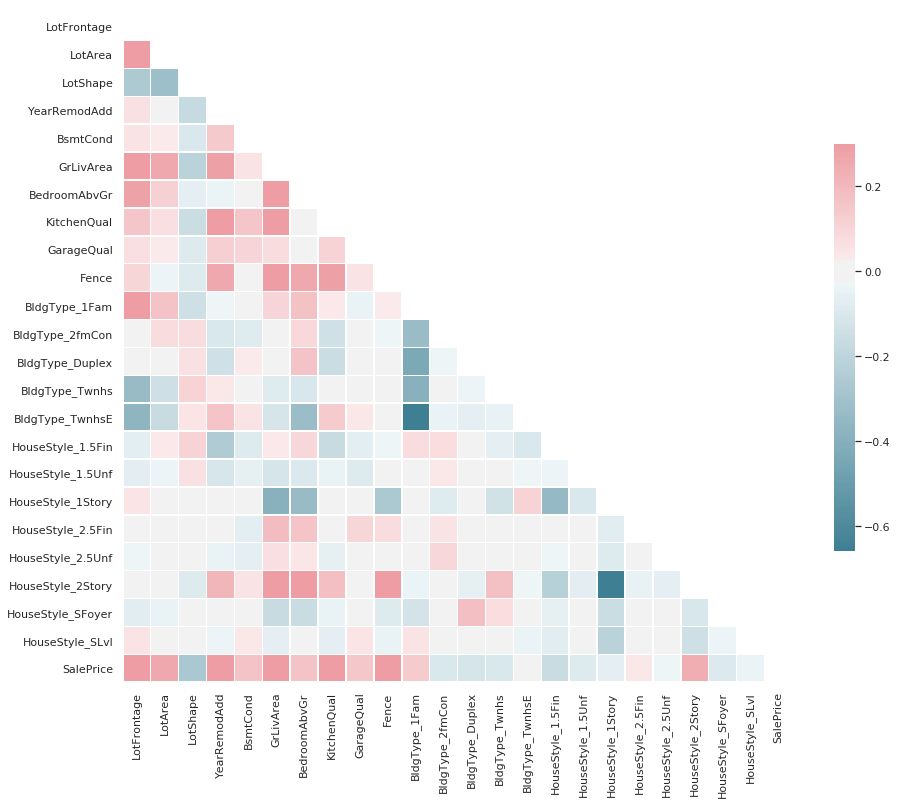

In [ ]:
# TODO: show visualization
interesting_variables = ['BedroomAbvGr', 'LotFrontage', 'KitchenQual', 'GrLivArea', 'BsmtCond', 'YearRemodAdd', 'HouseStyle', 'BldgType', 'SalePrice',
                         'GarageQual', 'LotShape', 'LotArea', 'Fence']
interesting_columns = list()
for column in data:
    for variable in interesting_variables:
        if (column==variable) or (column.startswith(variable+'_')):
            interesting_columns.append(column)

corr_df = data.loc[:,interesting_columns].copy()
corr_df = corr_df.corr()
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
sns.set(style='white')

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, cmap=cmap, vmax=.3, mask=mask, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()



> Discuss most positive and negative correlations.


**Notable highly Positive and Negative Correlations**
  *   Correlations among category types of same category aren't presented.

1.   **Positive Correlations**
  *   LotFrontage is positively correlated with LotArea, GrLivArea (above grade living area), BedroomsAboveGrade, 1 storey houses, KitchenQuality and SalePrice. 
  *   Higher the Lot Area, higher the AboveGradeLivingArea and SalePrice. Also, it is interesting to note that Lot Area is highly positively correlated with Single-family Detached buildings i.e., More or all Single-family Detached buildings are constructed in larger lots.
  
  *   YearRemodAdd (recent remodelled year) is positively correlated with KitchenQuality, GarageQuality, Good BasementCondition and SalePrice, which is expected. It is interesting to note that, YearRemodAdd is positively correlated with Townhouse End Unit and Two Storey houses.
  
  *   BsmtCond is positively correlated with SalePrice i.e., the BasementCondition is good, SalePrice is high.
  
  *   Fence (High privacy) is positively correlated with YearRemodAdd, GrLivArea, BedroomsAboveGrade, 2 Storey buildings and SalePrice.
  
  *   GrLivArea (above grade living area) is positively correlated with BedroomAbvGr (bedrooms above grade), 2 Storey houses, SalePrice and Kitchenquality.
  *   BedroomAbvGr (bedrooms above grade) is positively correlated with 2 Storey buildings.
  *   KitchenQuality is positively correlated with 2 Story houses and SalePrice (high correlation).
  *   GarageQuality, Single-family Detached buildings, 2 Storey houses are positively correlated with SalePrice.



2.   **Negative Correlations**
  *   LotFrontage is negatively correlated with Townhouse dwellings. Also, more irregular the LotShape lower the LotFrontage.
  *   Lot Area is negatively correlated with Lot Shape i.e., Higher the Lot Area, more irregular is the lot shape. 
  *   Lot Shape is negatively correlated with SalePrice i.e., more irregular the lot shape, higher the cost. This might be because the irregular ones are of more lot area. Irregular the lot shape, higher the GrLivArea (above grade living area).
  *   YearRemodAdd is negatively correlated with 1.5Fin (One and one-half story: 2nd level finished type) houses.
  *   Fence (High privacy) is negatively correlated with 1 storey houses.
  *   BedroomAbvGr (bedrooms above grade) is negatively correlated with 1 storey houses.
  *   GrLivArea (above grade living area) is negatively correlated with 1 storey houses.


## Part 2 - Informative Plots

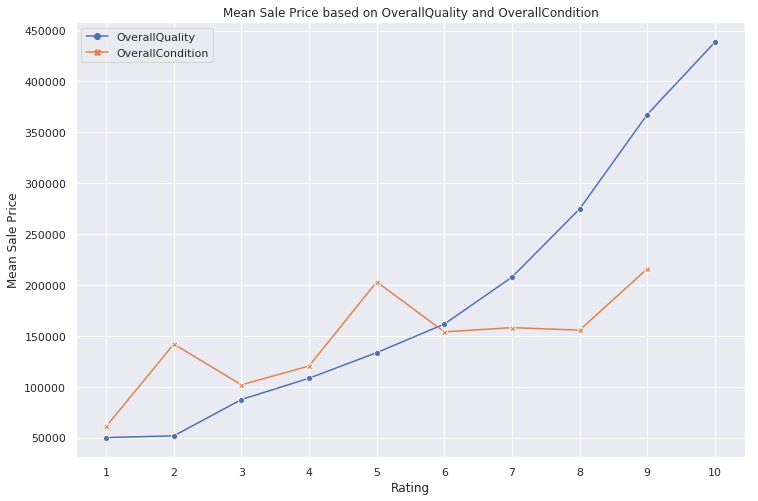

In [ ]:
# TODO: code to generate Plot 1
quality_wise_sale_price = data.groupby('OverallQual')['SalePrice'].mean()
cond_wise_sale_price = data.groupby('OverallCond')['SalePrice'].mean()
dataframe = pd.DataFrame([quality_wise_sale_price, cond_wise_sale_price],
                           index = ['OverallQuality', 'OverallCondition']).transpose()
# print(dataframe)
plt.figure(figsize=(12, 8))
plt.xticks(np.arange(0, 11, 1))
sns.lineplot(data=dataframe, dashes=False, markers= True)
plt.title('Mean Sale Price based on OverallQuality and OverallCondition')
plt.xlabel('Rating')
plt.ylabel('Mean Sale Price')
plt.show()

What interesting properties does Plot 1 reveal?


> We don't really know how exactly various features of a house are  used to come up with OverallQuality and OverallCondition. Even if these features are good reflection of OverallQuality and OverallCondition of a house, I was curious to know which of the quality and condition gives better price estimates. From the plot we can infer that SalePrice increases monotonously with OverallQuality which tells how significant the (Quality of the house) is in Price determination. In case of OverallCondition, the price increase isn't monotonous which implies there are other factors which play more important role in price prediction than Condition of the house.  



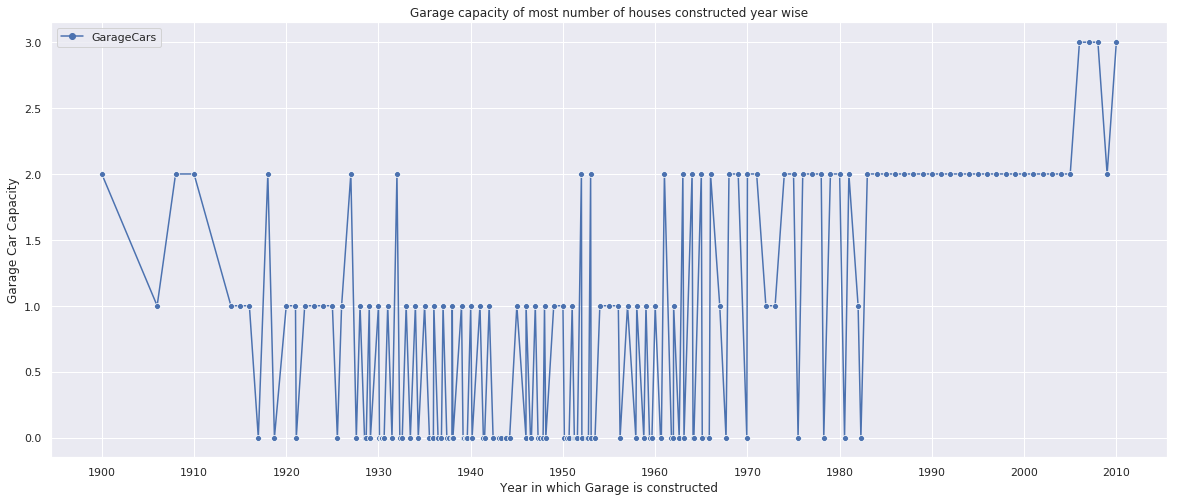

In [ ]:
# TODO: code to generate Plot 2
garage_year_wise_garage_cars = data.groupby('GarageYrBlt')['GarageCars'].agg(pd.Series.mode).to_frame()
garage_year_wise_garage_cars = garage_year_wise_garage_cars.GarageCars.apply(pd.Series)[0].to_frame()
garage_year_wise_garage_cars.rename(columns={0:'GarageCars'}, inplace=True)
# print(garage_year_wise_garage_cars)
plt.figure(figsize=(20, 8))
plt.xticks(np.arange(1900, 2011, 10))
sns.lineplot(data=garage_year_wise_garage_cars, dashes=False, markers= True)
plt.ylabel('Garage Car Capacity')
plt.xlabel('Year in which Garage is constructed')
plt.title('Garage capacity of most number of houses constructed year wise')
plt.show()

What interesting properties does Plot 2 reveal?


> From 1900 to 1915, people constructed houses with garage capacity of either 1 or 2. In those times, having a car is great deal. So we can say that people who lived there in early 1900's are affluent. From 1915 to 1960, garage capacity of houses constructed is either 0 or 1 implying that middle class people too started living in the region. From 1960's to 2010, we see garage capacities raise to 2 and then 3. This implies both how important car has become for a household and also improvement in economy and that car is no longer a commodity owned by just rich people as house prices of houses constructed aren't touching rooftops. Thus, we can estimate economic demographics and car value from the plot.



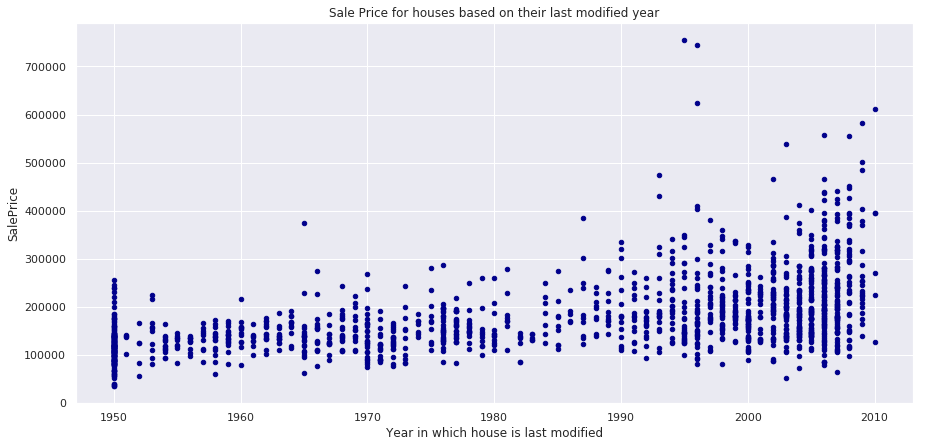

In [ ]:
# TODO: code to generate Plot 3
df = raw_data[['YearRemodAdd', 'SalePrice']]
df.plot(kind='scatter', x='YearRemodAdd', y='SalePrice', rot=0, c='DarkBlue', figsize=(15,7))
plt.ylabel('SalePrice')
plt.xlabel('Year in which house is last modified')
plt.title('Sale Price for houses based on their last modified year')
plt.show()

What interesting properties does Plot 3 reveal?


> There are certain aspects of a house which make them stand out of rest of the houses and are thus priced highly. From the plot, we can infer that there are some houses which were last modified/renovated/constructed in 1964-65, 1985-88, 1990-1997, but are still priced highly and stayed relevant in time. If we check the aspects of these houses, we would know which key features helped these houses stay relevant and can be used for price modelling. The plot reveals that there are some old houses which don't have state of the art architecture but are priced very high in comparision to houses last modified around the same time.



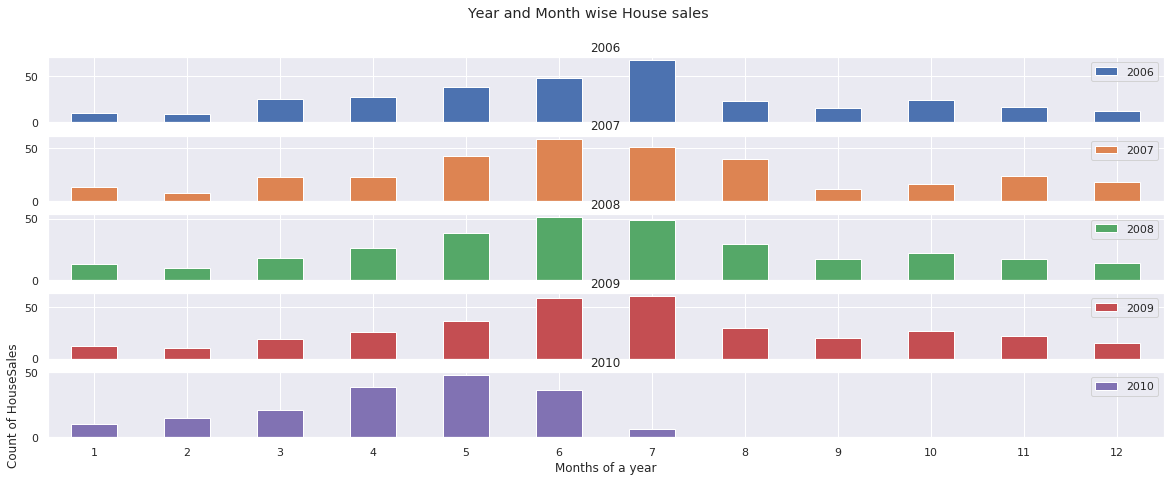

In [ ]:
# TODO: code to generate Plot 4
location_condition_wise_mean_price = raw_data.groupby(['MoSold', 'YrSold'])['Id'].count()
location_condition_wise_mean_price.unstack(level=1).plot(kind='bar', subplots=True, rot=0, figsize=(20,7), title="Year and Month wise House sales")
plt.ylabel('Count of HouseSales')
plt.xlabel('Months of a year')
plt.show()

What interesting properties does Plot 4 reveal?


> The plot reveals that the house sales peaked around the middle of an year consistently. The data for year 2010 is incomplete.



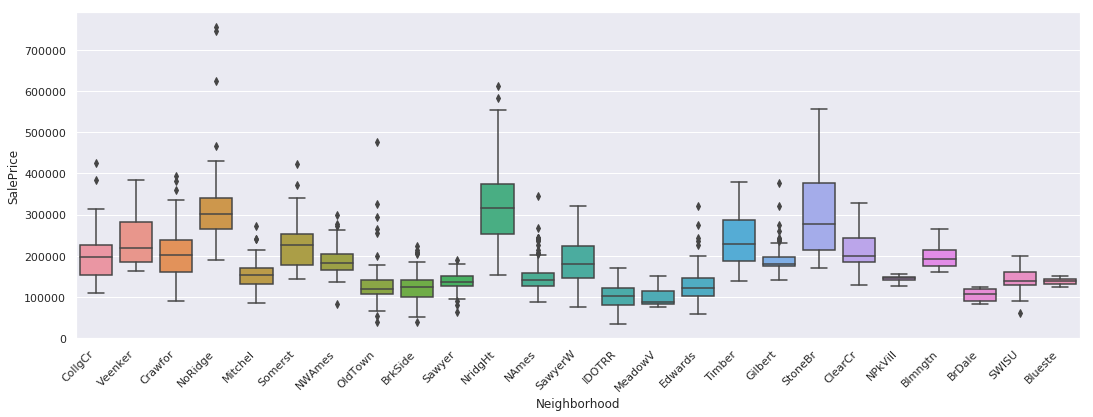

In [ ]:
plt.figure(figsize=(18, 6))
box_plot = sns.boxplot(data=raw_data, x='Neighborhood', y='SalePrice')
box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

What interesting properties does Plot 5 reveal?


> From the plot we can infer that the costly houses and the affluent people are mostly in neighborhoods NoRidge, NridgHt and StoneBr. Usually a small neighborhood tends to have houses of similar prices and a big neighborhood would have wide range of houses priced differently. Based on the variance (distance between whiskers of a box plot) of house prices, we can estimate to a certain extent the size of the neighborhood. The variance in house prices are least in Blueste and NPkVill suggesting they could be small communities in comparision to others and the variance in house prices is highest for NridgHt and StoneBr suggesting that they could be big communities.



## Part 3 - Handcrafted Scoring Function

In [ ]:
# TODO: code for scoring function
#Normalizing data other than Id, SalePrice
saleprice_data = data['SalePrice'].copy()

scaled_data = scale_data(data)

features_considered = ['OverallQual', 'ExterQual', 'BsmtQual', 'GrLivArea','OverallCond',
                       'KitchenQual', 'LotFrontage', 'LotArea', 'BedroomAbvGr', 'TotRmsAbvGrd']

scaled_data['desirability'] = scaled_data[features_considered].sum(axis=1)

scaled_data['Actual_SalePrice'] = saleprice_data
scaled_data.sort_values(by=['desirability'], inplace=True)
raw_data.sort_values(by=['SalePrice'], inplace=True)
print('Following are the houses with least desirability and their saleprices')
print(scaled_data[['desirability', 'Actual_SalePrice']].head(n=10))
print('\n\nFollowing are the houses with least saleprices')
print(raw_data['SalePrice'].head(n=10))
print('\n\nFollowing are the houses with highest desirability and their saleprices')
print(scaled_data[['desirability', 'Actual_SalePrice']].tail(n=10))
print('\n\nFollowing are the houses with highest saleprices')
print(raw_data['SalePrice'].tail(n=10))



Following are the houses with least desirability and their saleprices
      desirability  Actual_SalePrice
375       2.186725             61000
533       2.321035             39300
636       2.677213             60000
1100      3.003192             60000
916       3.030681             35311
821       3.165626             93000
1000      3.216558             82000
88        3.246079             85000
250       3.357846             76500
341       3.359938             82000


Following are the houses with least saleprices
495     34900
916     35311
968     37900
533     39300
30      40000
710     52000
1337    52500
705     55000
1325    55000
812     55993
Name: SalePrice, dtype: int64


Following are the houses with highest desirability and their saleprices
      desirability  Actual_SalePrice
11        6.480143            345000
769       6.492608            538000
1169      6.555831            625000
798       6.692881            485000
803       6.719264            582933
185     

What is the ten most desirable houses?

> Houses with Ids 349, 11, 769, 1169, 798, 803, 1182, 691, 523, 1298 are the most desirable houses.



What is the ten least desirable houses?


> Houses with Ids 533, 375, 636, 1100, 916, 1323, 821, 29, 935, 1213 are the least desirable houses.



Describe your scoring function and how well you think it worked.

> My scoring function considered 'OverallQual', 'OverallCond', 'ExterQual', 'BsmtQual', 'GrLivArea', 'KitchenQual', 'LotFrontage', 'LotArea', 'BedroomAbvGr', 'TotRmsAbvGrd' features for evaluating desirability of a house. I felt that the mentioned features are key in deciding the desirability of a house and also felt that all the features I specified are **equally** important and thus didn't scale the already normalized features and thus summed up the **featurewise_normalized** feature values for a house. 


> It worked very well because for the features I considered for desirability evaluation, the correlation of SalePrices with the desirability should be good which is evident from the output of the above cell. An interesting observation is that my most desirable house isn't priced as high as the costliest houses. This is explained by the fact that the house has very good value of the features I have considered and yet priced less. 





## Part 4 - Pairwise Distance Function

In [ ]:
# TODO: code for distance function
from scipy.spatial.distance import pdist

scaled_data = scale_data(data)
features_considered = ['OverallQual', 'ExterQual', 'BsmtQual', 'GrLivArea', 'GarageQual', 'OverallCond',
                       'KitchenQual', 'LotFrontage', 'LotArea', 'BedroomAbvGr', 'TotRmsAbvGrd']

consider_columns = list()
for feature in features_considered:
    for column in scaled_data.columns:
        if column.startswith(feature):
            consider_columns.append(column)

data_distance = pdist(scaled_data[consider_columns], 'euclidean').reshape(-1,1)

saleprice_data_numpy = saleprice_data.to_numpy().reshape(-1,1)
saleprice_data_distance = pdist(saleprice_data_numpy, 'euclidean').reshape(-1,1)

correlation_coeff = np.corrcoef(data_distance, saleprice_data_distance, rowvar=False)
print("The correlation between distance values computed by the distance function and difference in SalePrices is {}".format(correlation_coeff[0][1]))

The correlation between distance values computed by the distance function and difference in SalePrices is 0.6120843439006493


How well does the distance function work? When does it do well/badly?


> Most attributes of a house are captured in abstract parameters like **Quality**(OverallQual, ExterQual, BsmtQual, GarageQual, KitchenQual) and **Condition**(OverallCond) and some key parameters like GrLivArea (Above Grade Living Area), LotArea, LotFrontage, BedroomAbvGr, TotRmsAbvGrd. So these features should be a good projection of a house. I used euclidean distance computed between two houses, on the normalized features we just discussed. The distance function works very well because, the distance measure between two houses turns out to have a very good correlation with the differences in the SalePrices of the houses and it is **0.61208434** output by the above cell, which is to a certain extent a good measure of a distance function.

> This distance function does well when the similarities/differences between the houses are captured by the features chosen for distance function evaluation and wouldn't do well when the similarities/differences between the houses are present in some other key features which I didn't choose for measuring the distance. But the features I chose are kind of holistic.





## Part 5 - Clustering

(1460, 2) <class 'numpy.ndarray'>


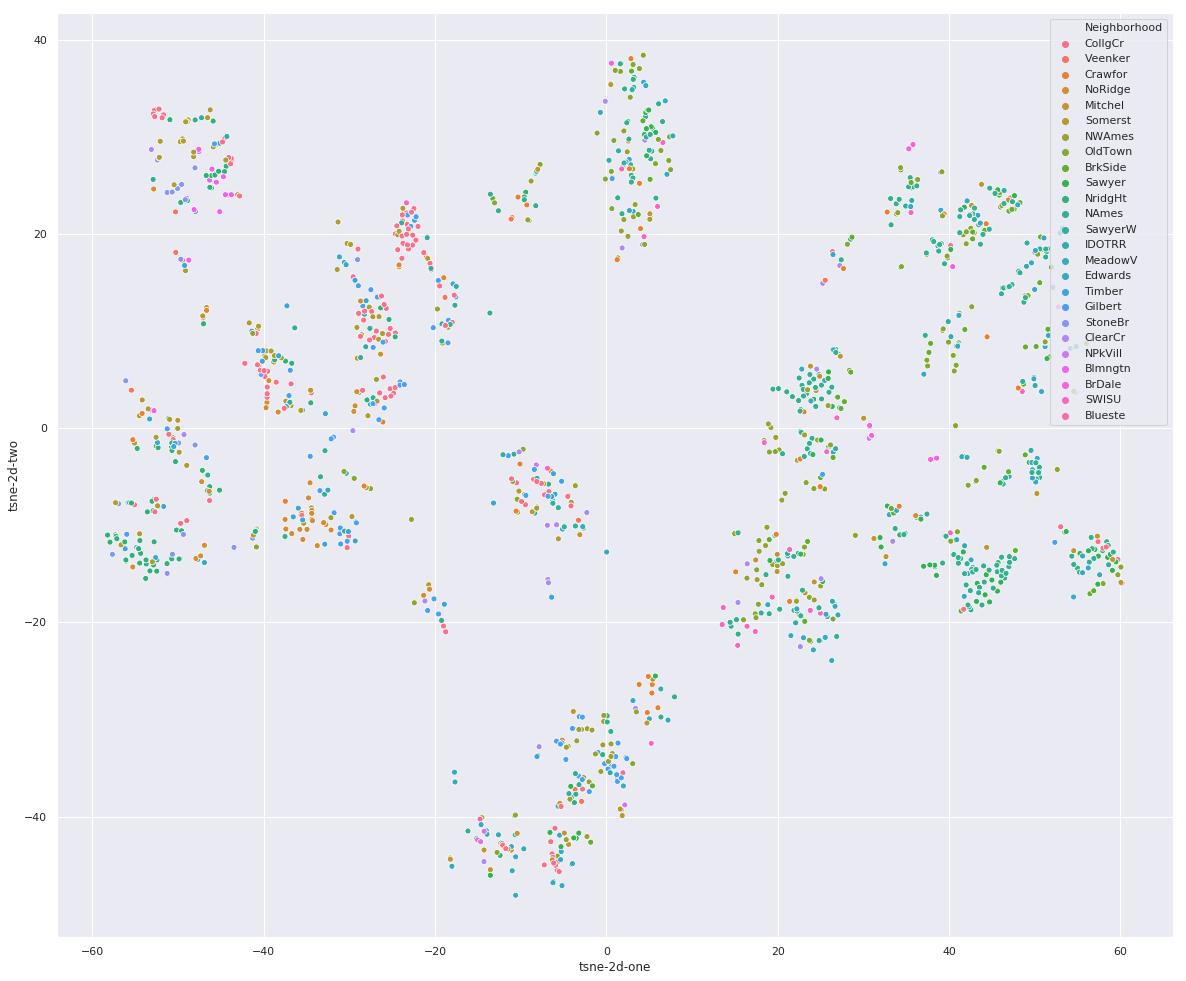

In [ ]:
# TODO: code for clustering and visualization
from sklearn.manifold import TSNE

scaled_data = scale_data(data)

features_considered = ['OverallQual', 'ExterQual', 'BsmtQual', 'GrLivArea',
                       'KitchenQual', 'LotFrontage', 'LotArea', 'BedroomAbvGr', 'TotRmsAbvGrd']
X = scaled_data[features_considered]
# Y = scaled_data['SalePrice']

tsne_results = TSNE(n_components=2, metric='euclidean').fit_transform(X)
print(tsne_results.shape, type(tsne_results))
df_components = pd.DataFrame()
df_components['tsne-2d-one'] = tsne_results[:,0]
df_components['tsne-2d-two'] = tsne_results[:,1]
df_components['Neighborhood'] = raw_data['Neighborhood']
plt.figure(figsize=(20,17))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="Neighborhood", data=df_components)
plt.show()

How well do the clusters reflect neighborhood boundaries? Write a discussion on what your clusters capture and how well they work.

> T-SNE is used for dimensionality reduction from 9 features to 2 features. There are around 20 clusters. Neighborhoods are captured very well i.e., even though not all clusters can be identified solely by a neighborhood (colour), neighborhoods occurred in clusters in the above plot (data points of same colour are in clusters in the plot).



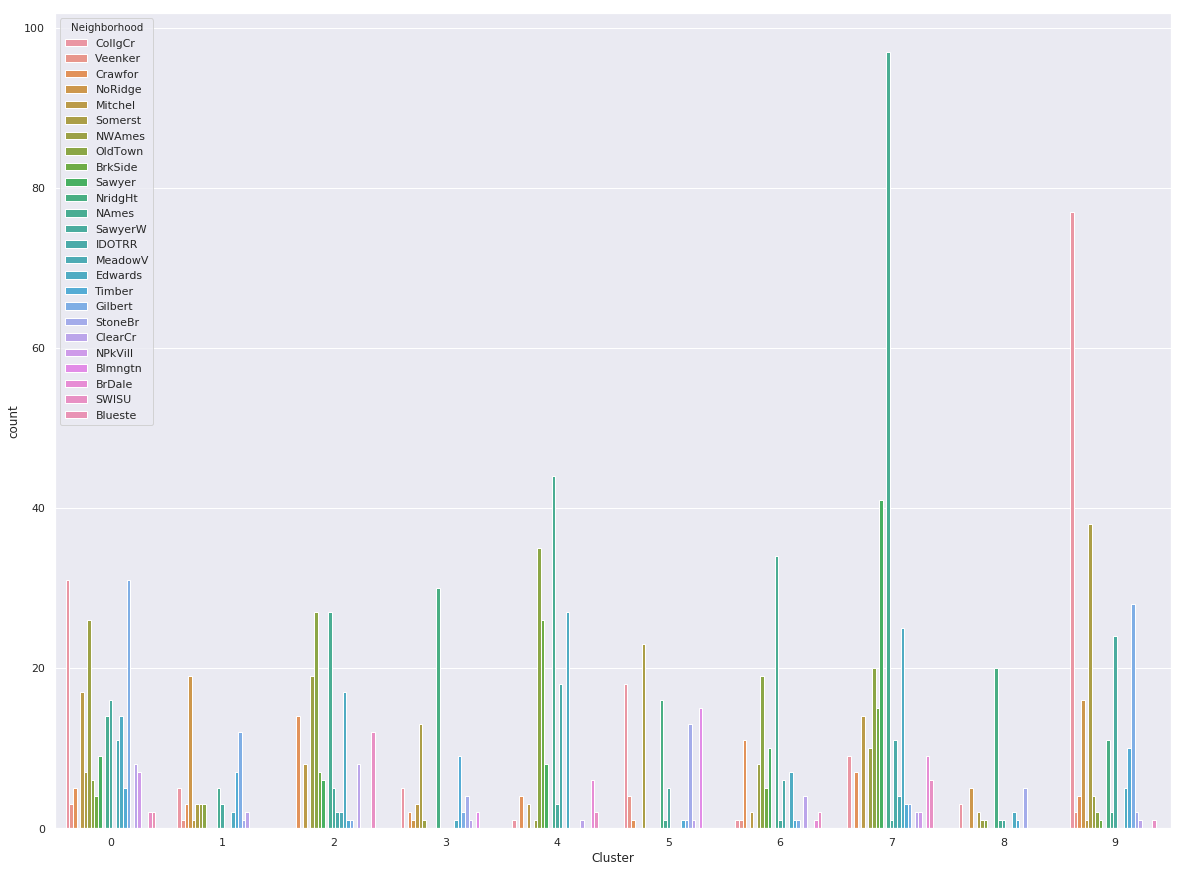

In [ ]:

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
scaled_data = scale_data(data)

# features_considered = ['OverallQual']

features_considered = ['OverallQual', 'ExterQual', 'BsmtQual', 'GrLivArea',
                       'KitchenQual', 'LotFrontage', 'LotArea', 'BedroomAbvGr', 'TotRmsAbvGrd']

X = scaled_data[features_considered]

clustering_model = AgglomerativeClustering(n_clusters=10)
clustering_model.fit(X)

cluster_df = pd.DataFrame()
cluster_df['Cluster'] = clustering_model.labels_
cluster_df['Neighborhood'] = raw_data['Neighborhood']

plt.figure(figsize=(20, 15))
sns.countplot(x="Cluster", hue="Neighborhood", data=cluster_df)
plt.show()

> The clusters formed through T-SNE don't clearly provide the count of neighborhoods captured by the clusters. So also presenting a count wise neighborhood distribution among 10 clusters using the same distance function. When 10 clusters are formed on 25 Neighborhoods using AgglomerativeClustering utilizing the same distance function defined previously (eucledian distance on selected normalized features), we observe that the most fraction (proportional to length of bars) of most neighborhoods is captured in 1-3 clusters.




## Part 6 - Linear Regression

In [ ]:
# TODO: code for linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

features_considered = ['OverallQual', 'ExterQual', 'BsmtQual', 'GrLivArea', 'Neighborhood', 'MSSubClass',
                       'KitchenQual', 'LotFrontage', 'LotArea', 'BedroomAbvGr', 'TotRmsAbvGrd']

scaled_data = scale_data(data)
Y = scaled_data['SalePrice']

for feature in features_considered:
    consider_columns = list()
    for column in scaled_data.columns:
        if column.startswith(feature):
            consider_columns.append(column)
    X_train, X_test, y_train, y_test = train_test_split(scaled_data[consider_columns], Y, test_size=0.35, random_state=5)
    reg = LinearRegression().fit(X_train.to_numpy().reshape(-1, len(consider_columns)), y_train.to_numpy().reshape(-1,1))
    score = reg.score(X_test.to_numpy().reshape(-1,len(consider_columns)), y_test.to_numpy().reshape(-1,1))
    print("Feature used for prediction: {} and the score: {}".format(feature, str(score)))

Feature used for prediction: OverallQual and the score: 0.6073677285298563
Feature used for prediction: ExterQual and the score: 0.48924564192816783
Feature used for prediction: BsmtQual and the score: 0.34351858991081086
Feature used for prediction: GrLivArea and the score: 0.5512695520721071
Feature used for prediction: Neighborhood and the score: 0.4964262670959323
Feature used for prediction: MSSubClass and the score: 0.2511393820539416
Feature used for prediction: KitchenQual and the score: 0.41447655631688257
Feature used for prediction: LotFrontage and the score: 0.10332103178889705
Feature used for prediction: LotArea and the score: 0.07631912597484614
Feature used for prediction: BedroomAbvGr and the score: 0.027787420495080317
Feature used for prediction: TotRmsAbvGrd and the score: 0.2892338541585444


How well/badly does it work? Which are the most important variables?

> Some features specified by the outcome of the above cell did pretty well in SalePrice prediction. The score output by the above cell is the coefficient R^2 which is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). OverallQual, GrLivArea, ExterQual, Neighborhood are very good predictors of SalePrice.



## Part 7 - External Dataset

In [ ]:
# TODO: code to import external dataset and test
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

house_price_index_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/house-prices-advanced-regression-techniques/ATNHPIUS11180Q.csv")
iowa_house_ownership_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/house-prices-advanced-regression-techniques/IAHOWN.csv")
house_price_index_data['DATE'] = house_price_index_data['DATE'].str.split('-', expand=True)[0]
house_price_index_data['DATE'] = house_price_index_data['DATE'].astype('float64')
house_price_index_data = house_price_index_data.groupby('DATE')['ATNHPIUS11180Q'].mean().to_frame()
house_price_index_data.reset_index(inplace=True)
house_price_index_data['DATE'] = house_price_index_data['DATE'].astype('int64')
iowa_house_ownership_data['DATE'] = iowa_house_ownership_data['DATE'].str.split('-', expand=True)[0]
iowa_house_ownership_data['DATE'] = iowa_house_ownership_data['DATE'].astype('int64')
data['YrSold'] = data['YrSold'].astype('int64')
house_price_index_data.rename(columns={'DATE':'YrSold'}, inplace=True)
iowa_house_ownership_data.rename(columns={'DATE':'YrSold'}, inplace=True)
data_1 = pd.merge(data, house_price_index_data, on='YrSold', how='inner')         # ATNHPIUS11180Q (Ames housing price index incorporated)
data_1 = pd.merge(data_1, iowa_house_ownership_data, on='YrSold', how='inner')     # IAHOWN (House ownership index incorporated)
data_1 = scale_data(data_1)

selected_columns = ['ATNHPIUS11180Q', 'IAHOWN']
for column in selected_columns:
    X_train, X_test, y_train, y_test = train_test_split(data_1[column], scaled_data['SalePrice'], test_size=0.35, random_state=5)
    reg = LinearRegression().fit(X_train.to_numpy().reshape(-1, 1), y_train.to_numpy().reshape(-1,1))
    score = reg.score(X_test.to_numpy().reshape(-1,1), y_test.to_numpy().reshape(-1,1))
    print("Feature used for prediction: {} and the score: {}".format(column, str(score)))

Feature used for prediction: ATNHPIUS11180Q and the score: -0.0016880225131481461
Feature used for prediction: IAHOWN and the score: -9.237842016629472e-05


Describe the dataset and whether this data helps with prediction.


> When incorporating external dataset, if we don't add data corresponding to the same region (Ames housing price index, Iowa (same state) house ownership index) we would add noise to the data and degrade the pre-existing dataset. There were boston housing dataset and other region housing datasets that fall in this noise addition dataset categories. Also we've captured the relations of existing attributes in dataset. So, considered **Ames housing price index dataset** and **Iowa House Ownership Index**. The features added are the ATNHPIUS11180Q (housing price index) and IAHOWN (house ownership  index) by joining on the year in which house is sold with year wise information of datasets. Both these features are poor predictors of sale price which is evident from the scores they produced when fit to predict SalePrice. So, won't be considering these features for model construction.



## Part 8 - Permutation Test

In [ ]:
# TODO: code for all permutation tests
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression

def rms_error_log_price(y_true, y_pred):
    from sklearn.metrics import mean_squared_error
    from math import sqrt
    y_pred[y_pred<=0]=1     
    rms = sqrt(mean_squared_error(np.log(y_true), np.log(y_pred)))
    return rms

features_considered = ['OverallQual', 'ExterQual', 'Fence', 'GrLivArea', 'Neighborhood', 'MoSold',
                       'KitchenQual', 'LotFrontage', 'LotArea', 'BedroomAbvGr', 'TotRmsAbvGrd']

scaled_data = scale_data(data)
Y = scaled_data['SalePrice']

for feature in features_considered:
    consider_columns = list()
    for column in scaled_data.columns:
        if column.startswith(feature):
            consider_columns.append(column)
    reg = LinearRegression()
  
    rmse_scorer = make_scorer(rms_error_log_price, greater_is_better=False)
  
    score = permutation_test_score(reg, scaled_data[consider_columns].to_numpy().reshape(-1, len(consider_columns)), Y.to_numpy().reshape(-1,1),
                         n_permutations=250, cv=3,scoring=rmse_scorer)
  
    print("Feature used for prediction: {} and the p-value: {}".format(feature, str(score[2])))

Feature used for prediction: OverallQual and the p-value: 0.00398406374501992
Feature used for prediction: ExterQual and the p-value: 0.00398406374501992
Feature used for prediction: Fence and the p-value: 0.00398406374501992
Feature used for prediction: GrLivArea and the p-value: 0.00398406374501992
Feature used for prediction: Neighborhood and the p-value: 0.00398406374501992
Feature used for prediction: MoSold and the p-value: 0.3705179282868526
Feature used for prediction: KitchenQual and the p-value: 0.00398406374501992
Feature used for prediction: LotFrontage and the p-value: 0.00398406374501992
Feature used for prediction: LotArea and the p-value: 0.00398406374501992
Feature used for prediction: BedroomAbvGr and the p-value: 0.00398406374501992
Feature used for prediction: TotRmsAbvGrd and the p-value: 0.00398406374501992


Describe the results.


> In the output of the above cell, features and the p-value associated with them are presented when 250 permutations are run. MoSold (MonthSold) has a poor p-value which is 0.37 which implies that randomly permuted prices are better predictions of the SalePrice 37 times than predictions generated by MoSold feature when such random permutations are produced 100 times. Other features in the output are better predictors as compared to random permutations of prices in 99.6% of the cases.



## Part 9 - Prediction Model

### Steps taken in Model Construction:


1.   **Data Preprocessing**

 *   Initially, all features are considered. Then, dropped the features (columns) in which NaN values are very high.
 
 *   For each categorical variable, the ones which are ordinal are converted to numbers maintaining the relationship. Data imputation is done filling the NaN values with most frequent category.

 *   Once, Data Imputation of categorical features is done, the features are one hot encoded.
 
 *   Then Data Imputation for Non-Categorical features is done using Round-Robin style linear regression, where each missing value is predicted using other feature values of the data instance. Initialization is done with Mean of the feature and then iteratively estimated using linear regression technique fitted on other features of the same instance. **sklearn.impute.IterativeImputer** is used for this step.
 
 *   Finally, the data is normalized i.e., feature vectors are made of unit length. **sklearn.preprocessing.normalize** is used for this purpose.

 *   The treatment of Test Data is done the same way it is done for training data (dropping the exact columns, imputing categorical features with same category as the ones in training data, normalizing the data and using same iterative imputer to transorm test data.)
 
2.   **Training and Validation of the Model** 

 *   Gradient Boosting Regressor is used for the classification. Gradient Boosting Regressor is an ensemble of weak learners. Each of these weak learners, if used to predict the prices for entire dataset would do poorly. The predictions of the weak learners are weighted by their accuracy values and shrinkage is applied on each of them, so that, it requires more weak learners for the ensemble to do well and one of them alone won't be responsible for correct SalePrice prediction of data points in large feature space. Gradient Boosting Regressor is an iterative stage-wise, Functional Gradient Descent optimization problem, in which each new hypothesis (weak learner added to the ensemble) added to pre-existing whole hypothesis, is meant to take the step in the direction of Steepest Gradient of Loss function (Mean Square Error) with respect to pre-existing hypothesis i.e., construct a weak learner that predicts the previously poorly predicted instances, well. This is **Functional** Gradient Descent optimization because here we aren't trying to learn parameters, rather we are trying to learn a hypothesis (weak learner) that is to be added to pre-existing hypothesis (ensemble) at each stage. **sklearn.ensemble.GradientBoostingRegressor** is used for this purpose.
 
 *   max_features of 0.8 fraction is used i.e., in the construction of each weak learner 0.8 fraction of randomly sampled features are used. This helps in fast convergence and reduced over-fitting of the model. When the performance doesn't improve further for n_iter_no_change iterations on HeldOut data (validation_fraction=0.25) which is 25% of training data, the training stops. Each weak learner can be of a maximum depth 3. Once the training and validation is done, the model is fit to test data and results are reported.


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

train_data_y = data['SalePrice']
train_data_x = data.drop(columns=['SalePrice', 'Id'])
# index = train_data_x.index
# columns = train_data_x.columns
# train_data_x = normalize(train_data_x, axis=0)
# train_data_x = pd.DataFrame(train_data_x, index=index, columns=columns)
train_data_x = scale_data(train_data_x)
      

from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(train_data_x, train_data_y, test_size=0.2, random_state=5)
regr = GradientBoostingRegressor(n_estimators = 1000, verbose=1, subsample=1, max_features=0.8, max_depth=3, validation_fraction=0.25, n_iter_no_change=15)
regr.fit(train_data_x, train_data_y) 
# print(regr.score(X_test, y_test))

In [ ]:
test_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/house-prices-advanced-regression-techniques/test.csv")
test_id_data = test_data['Id']
test_data.drop(columns=pre_process_tracker.drop_columns, inplace=True)
test_data.drop(columns=['Id'], inplace=True)
test_data = convert_ordinal_to_numbers(test_data)
test_data = pre_process_tracker.fit_categorical_imputer(test_data, fit_and_transform=False)
test_data = pre_process_tracker.construct_one_hot_encoder_fit_transform_data(test_data, fit_and_transform=False)
test_data = pre_process_tracker.fit_iterative_imputer(test_data, fit_and_transform=False)
# index = test_data.index
# columns = test_data.columns
# test_data = normalize(test_data, axis=0)
# test_data = pd.DataFrame(test_data, index=index, columns=columns)
test_data = scale_data(test_data)

[IterativeImputer] Completing matrix with shape (1459, 236)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.01


In [ ]:
test_pred = regr.predict(test_data)
pred_dataframe = pd.DataFrame({'Id': np.array(test_id_data), 'SalePrice': test_pred})
pred_dataframe.to_csv('Submission2.csv', index=False)

## Part 10 - Final Result

Report the rank, score, number of entries, for your highest rank. Include a snapshot of your best score on the leaderboard as confirmation. Be sure to provide a link to your Kaggle profile. Make sure to include a screenshot of your ranking. Make sure your profile includes your face and affiliation with SBU.

Kaggle Link: https://www.kaggle.com/koushikdotdet

Highest Rank: 2269

Score: 0.13587

Number of entries: 5

INCLUDE IMAGE OF YOUR KAGGLE RANKING

In [ ]:
uploaded = files.upload()

Saving kaggle_score_housing.png to kaggle_score_housing (1).png


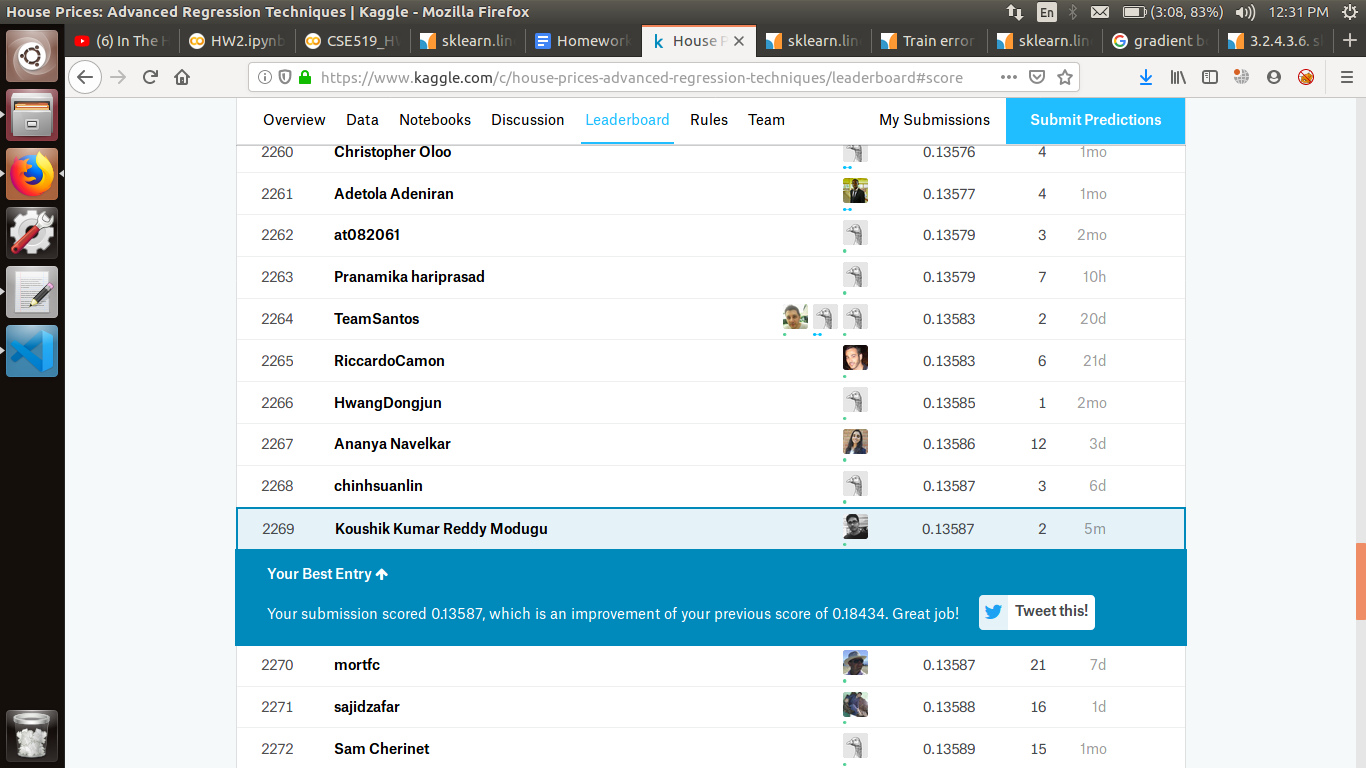

In [ ]:
Image('kaggle_score_housing.png')

# References


1.   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
2.   https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html

3.   https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
4.   https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist

5.   https://en.wikipedia.org/wiki/Gradient_boosting
6.   https://seaborn.pydata.org/tutorial/distributions.html

7.   https://pandas.pydata.org/pandas-docs/stable/reference/index.html
8.   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.permutation_test_score.html
9.   https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
10.  https://fred.stlouisfed.org/categories/30680